# Introduction
In this task, the client, the Category Manager for Chips, who wants to better understand the types of customers who purchase Chips and their purchasing behaviour within the region.
The insights from your analysis will feed into the supermarket’s strategic plan for the chip category in the next half year.

There are some important analysis must be explored:
- **Examine transaction data** 
- **Examine customer data**
- **Data analysis and customer segments**

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from IPython.display import display
from collections import Counter

In [315]:
trans = pd.read_excel('QVI_transaction_data.xlsx', parse_dates=['DATE'])
cust = pd.read_csv('QVI_purchase_behaviour.csv')

## Examine transaction data
Generally, to have a good feeling about the data we can use 3 methods from Pandas:
* DataFrame.head()
* DataFrame.info()
* DataFrame.describe()

First of all, I convert the interger data to readable date.
<br>.info() will be able to tell us if there is any missing values in the dataset.

Examining the dataset product name, we do find chips in the table. However, since we are only interested in chips analysis, we need to remove products that are not chips. Now, we have reduced the entries from 264836 to 74570. In total, there are 33 types of chips in the dataset.

In [326]:
trans['DATE'] = pd.to_datetime(trans['DATE'], errors='coerce', unit='d')

In [ ]:
trans.info()

In [10]:
display(trans.head())
display(cust.head())

DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
0 1974-12-13 22:00:00          1            1000       1         5   
1 1974-12-22 15:00:00          1            1307     348        66   
2 1974-12-22 21:00:00          1            1343     383        61   
3 1974-12-11 09:00:00          2            2373     974        69   
4 1974-12-11 10:00:00          2            2426    1038       108   

                                  PROD_NAME  PROD_QTY  TOT_SALES  
0    Natural Chip        Compny SeaSalt175g         2        6.0  
1                  CCs Nacho Cheese    175g         3        6.3  
2    Smiths Crinkle Cut  Chips Chicken 170g         2        2.9  
3    Smiths Chip Thinly  S/Cream&Onion 175g         5       15.0  
4  Kettle Tortilla ChpsHny&Jlpno Chili 150g         3       13.8

LYLTY_CARD_NBR               LIFESTAGE PREMIUM_CUSTOMER
0            1000   YOUNG SINGLES/COUPLES          Premium
1            1002   YOUNG SINGLES/COUPLES       Mainstream
2            1003          YOUNG FAMILIES           Budget
3            1004   OLDER SINGLES/COUPLES       Mainstream
4            1005  MIDAGE SINGLES/COUPLES       Mainstream

In [174]:
def remove_nonchips_prod(row):
    if 'chip' in row.lower():
        return True
    elif 'chips' in row.lower():
        return True
    elif 'chps' in row.lower():
        return True
    elif 'chp' in row.lower():
        return True
    return False
trans_chips = trans[trans['PROD_NAME'].apply(remove_nonchips_prod)]

In [184]:
def rename_chips(row):
    if row == 'Natural ChipCo      Hony Soy Chckn175g':
        return 'Natural ChipCo      Hony Soy Chckn 175g'
    if row == 'Natural Chip        Compny SeaSalt175g':
        return 'Natural Chip        Compny SeaSalt 175g'
    elif row == 'Smiths Chip Thinly  CutSalt/Vinegr175g':
        return 'Smiths Chip Thinly  CutSalt/Vinegr 175g'
    elif row == 'Smiths Crinkle Cut  Chips Chs&Onion170g':
        return 'Smiths Crinkle Cut  Chips Chs&Onion 170g'
    else:
        return row
trans_chips['PROD_NAME'] = trans_chips['PROD_NAME'].apply(rename_chips)

/Users/weshee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [185]:
prod_list = np.sort(trans_chips['PROD_NAME'].unique())
print('In total, there are {} types of chips sold to the customers.'.format(len(prod_list)))
print()
print(prod_list)

In total, there are 37 types of chips sold to the customers.

['Cobs Popd Sea Salt  Chips 110g' 'Cobs Popd Sour Crm  &Chives Chips 110g'
 'Cobs Popd Swt/Chlli &Sr/Cream Chips 110g'
 'Dorito Corn Chp     Supreme 380g'
 'Doritos Corn Chip Mexican Jalapeno 150g'
 'Doritos Corn Chip Southern Chicken 150g'
 'Doritos Corn Chips  Cheese Supreme 170g'
 'Doritos Corn Chips  Nacho Cheese 170g'
 'Doritos Corn Chips  Original 170g' 'French Fries Potato Chips 175g'
 'Kettle Tortilla ChpsBtroot&Ricotta 150g'
 'Kettle Tortilla ChpsFeta&Garlic 150g'
 'Kettle Tortilla ChpsHny&Jlpno Chili 150g'
 'Natural Chip        Compny SeaSalt 175g'
 'Natural Chip Co     Tmato Hrb&Spce 175g'
 'Natural ChipCo      Hony Soy Chckn 175g'
 'Natural ChipCo Sea  Salt & Vinegr 175g'
 'Smiths Chip Thinly  Cut Original 175g'
 'Smiths Chip Thinly  CutSalt/Vinegr 175g'
 'Smiths Chip Thinly  S/Cream&Onion 175g'
 'Smiths Crinkle Chips Salt & Vinegar 330g'
 'Smiths Crinkle Cut  Chips Barbecue 170g'
 'Smiths Crinkle Cut  Chips Chic

# Determine outliers
One method we can use to determine outlier is boxplot. From the boxplot below, we can see that it is abnormal for the store to sell the chips in quantity of 200. We can examine this customer further. It looks like the person who bought the 200 packets of chips is not ordinary consumer. I will remove the data from further analysis.

A more straightforward way is to use **.quantile** to identify 95% quantile and filter them out.

In [113]:
trans_chips[['PROD_QTY', 'TOT_SALES']].describe()

PROD_QTY     TOT_SALES
count  87335.000000  87335.000000
mean       1.910620      7.286420
std        1.007451      3.943887
min        1.000000      1.900000
25%        2.000000      6.000000
50%        2.000000      6.600000
75%        2.000000      8.800000
max      200.000000    650.000000

95% quantile for Total Sales is 11.8


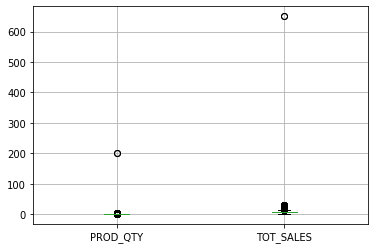

In [121]:
trans_chips[['PROD_QTY', 'TOT_SALES']].boxplot()
print('95% quantile for Total Sales is', trans_chips['TOT_SALES'].quantile(0.95))

In [120]:
print('Using masking, we can find that the person who buy 200 chips at once are from the same customer.')
print('Interestingly, further examination shows that the 2 transactions are the only transactions \
he made in the past.')

display(trans_chips[trans_chips['LYLTY_CARD_NBR'] == 226000])

Using masking, we can find that the person who buy 200 chips at once are from the same customer.
Interestingly, further examination shows that the 2 transactions are the only transactions he made in the past.


DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
69762 1974-12-11 11:00:00        226          226000  226201         4   
69763 1974-12-22 21:00:00        226          226000  226210         4   

                              PROD_NAME  PROD_QTY  TOT_SALES  
69762  Dorito Corn Chp     Supreme 380g       200      650.0  
69763  Dorito Corn Chp     Supreme 380g       200      650.0

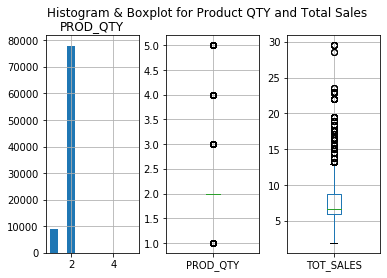

In [232]:
trans_filtered = trans_chips[(trans_chips['PROD_QTY'] < 100) & (trans_chips['TOT_SALES'] < 100)]
fig, axs = plt.subplots(1, 3)
fig.suptitle('Histogram & Boxplot for Product QTY and Total Sales')
trans_filtered[['PROD_QTY']].hist(ax=axs[0])
trans_filtered[['PROD_QTY']].boxplot(rot=0, ax=axs[1])
trans_filtered[['TOT_SALES']].boxplot(rot=0, ax=axs[2])
plt.show()

In [93]:
print('After filtering, the shape of the DataFrame is reduced from {} to {}'.format(trans.shape, trans_filtered.shape))
print('{} of rows has been removed'.format(trans.shape[0] - trans_filtered.shape[0]))

After filtering, the shape of the DataFrame is reduced from (264836, 8) to (246882, 8)
17954 of rows has been removed


There is a surge in demand of chips on 11/12 - 12/12 and 23/12 - 24/12. It is logical for us to deduce that the sales occurs before Christmas.

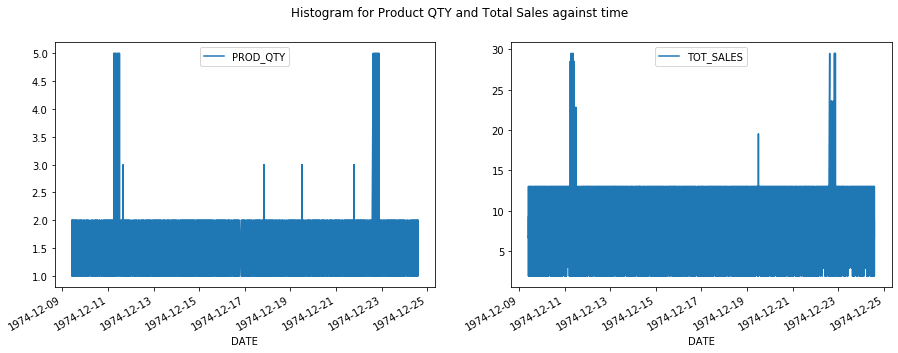

In [146]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Histogram for Product QTY and Total Sales against time')
trans_filtered.set_index('DATE')[['PROD_QTY']].plot(ax=axs[0])
trans_filtered.set_index('DATE')[['TOT_SALES']].plot(ax=axs[1])

Next, size and brands of the chips are extracted from the data. I will generate two extra columns for them. Asides, notice that Dorito and Doritos are looks like from the same brand. I will group them together too.

In [233]:
def pack_size(row):
    return row[-4:]
trans_filtered.insert(loc=8, column='PACK_SIZE', value=trans_filtered['PROD_NAME'].apply(pack_size))
trans_filtered.head()

DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
0 1974-12-13 22:00:00          1            1000       1         5   
2 1974-12-22 21:00:00          1            1343     383        61   
3 1974-12-11 09:00:00          2            2373     974        69   
4 1974-12-11 10:00:00          2            2426    1038       108   
6 1974-12-22 17:00:00          4            4149    3333        16   

                                  PROD_NAME  PROD_QTY  TOT_SALES PACK_SIZE  
0   Natural Chip        Compny SeaSalt 175g         2        6.0      175g  
2    Smiths Crinkle Cut  Chips Chicken 170g         2        2.9      170g  
3    Smiths Chip Thinly  S/Cream&Onion 175g         5       15.0      175g  
4  Kettle Tortilla ChpsHny&Jlpno Chili 150g         3       13.8      150g  
6  Smiths Crinkle Chips Salt & Vinegar 330g         1        5.7      330g

In [234]:
def brand(row):
    return row.split()[0]
trans_filtered.insert(loc=8, column='BRAND', value=trans_filtered['PROD_NAME'].apply(brand))

def brand_grouping(row):
    if row == 'Dorito':
        return 'Doritos'
    return row
trans_filtered['BRAND'] = trans_filtered['BRAND'].apply(brand_grouping)

trans_filtered.head()

/Users/weshee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
0 1974-12-13 22:00:00          1            1000       1         5   
2 1974-12-22 21:00:00          1            1343     383        61   
3 1974-12-11 09:00:00          2            2373     974        69   
4 1974-12-11 10:00:00          2            2426    1038       108   
6 1974-12-22 17:00:00          4            4149    3333        16   

                                  PROD_NAME  PROD_QTY  TOT_SALES    BRAND  \
0   Natural Chip        Compny SeaSalt 175g         2        6.0  Natural   
2    Smiths Crinkle Cut  Chips Chicken 170g         2        2.9   Smiths   
3    Smiths Chip Thinly  S/Cream&Onion 175g         5       15.0   Smiths   
4  Kettle Tortilla ChpsHny&Jlpno Chili 150g         3       13.8   Kettle   
6  Smiths Crinkle Chips Salt & Vinegar 330g         1        5.7   Smiths   

  PACK_SIZE  
0      175g  
2      170g  
3      175g  
4      150g  
6      330g

TOT_SALES
PACK_SIZE BRAND              
110g      Cobs           9693
150g      Doritos        6376
          Kettle         9580
160g      WW             2970
170g      Doritos        9498
          Smiths         5915
175g      French         1418
          Natural        6050
          Smiths         4527
          Thins         14075
          Tostitos       3145
200g      WW             4473
330g      Smiths         3197
380g      Doritos        3183
          Smiths         3233

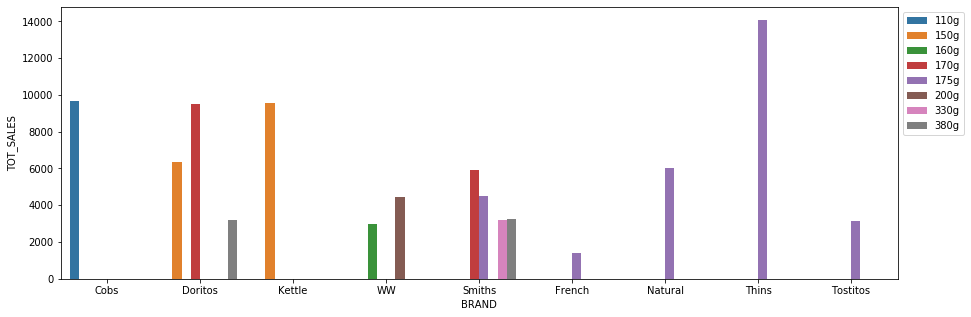

In [235]:
trans_filtered_count = trans_filtered.pivot_table(index=['PACK_SIZE', 'BRAND'], aggfunc='count', values='TOT_SALES')

display(trans_filtered_count)
plt.figure(figsize=(15,5))
sns.barplot(x='BRAND', y='TOT_SALES', hue='PACK_SIZE', data=trans_filtered_count.reset_index())
plt.legend(bbox_to_anchor=(1, 1))

TOT_SALES
PACK_SIZE BRAND              
110g      Cobs        70569.8
150g      Doritos     47622.9
          Kettle      84419.2
160g      WW          10647.6
170g      Doritos     79974.4
          Smiths      32422.0
175g      French       7929.0
          Natural     34272.0
          Smiths      25644.0
          Thins       88852.5
          Tostitos    26474.8
200g      WW          16007.5
330g      Smiths      34804.2
380g      Doritos     39052.0
          Smiths      36367.6

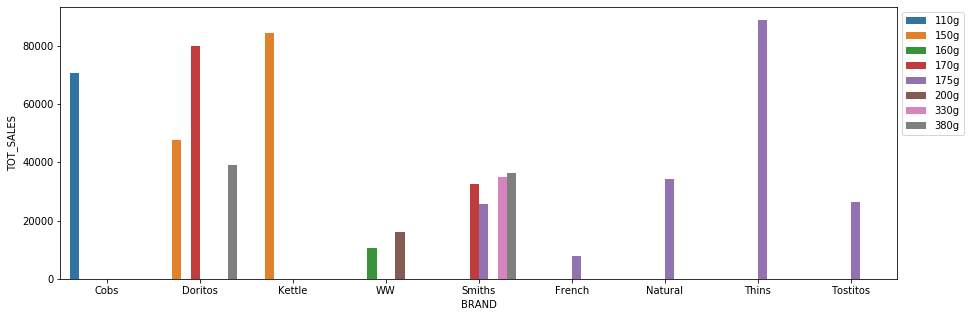

In [236]:
trans_filtered_sum = trans_filtered.pivot_table(index=['PACK_SIZE', 'BRAND'], aggfunc='sum', values='TOT_SALES')

display(trans_filtered_sum)
plt.figure(figsize=(15,5))
sns.barplot(x='BRAND', y='TOT_SALES', hue='PACK_SIZE', data=trans_filtered_sum.reset_index())
plt.legend(bbox_to_anchor=(1, 1))

## Examine customer data
Have a quick check, before and after merging of the transaction data and customer data, there is no missing values from the DataFrame.

In [104]:
cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [109]:
print('List of lifestage: ', cust['LIFESTAGE'].unique())
print('List of premium customer:', cust['PREMIUM_CUSTOMER'].unique())

List of lifestage:  ['YOUNG SINGLES/COUPLES' 'YOUNG FAMILIES' 'OLDER SINGLES/COUPLES'
 'MIDAGE SINGLES/COUPLES' 'NEW FAMILIES' 'OLDER FAMILIES' 'RETIREES']
List of premium customer: ['Premium' 'Mainstream' 'Budget']


In [237]:
# Merging customer data and transaction data
cust_trans = trans_filtered.merge(cust, on='LYLTY_CARD_NBR')

In [238]:
cust_trans.head()

DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
0 1974-12-13 22:00:00          1            1000       1         5   
1 1974-12-22 21:00:00          1            1343     383        61   
2 1974-12-11 09:00:00          2            2373     974        69   
3 1974-12-11 10:00:00          2            2426    1038       108   
4 1974-12-22 17:00:00          4            4149    3333        16   

                                  PROD_NAME  PROD_QTY  TOT_SALES    BRAND  \
0   Natural Chip        Compny SeaSalt 175g         2        6.0  Natural   
1    Smiths Crinkle Cut  Chips Chicken 170g         2        2.9   Smiths   
2    Smiths Chip Thinly  S/Cream&Onion 175g         5       15.0   Smiths   
3  Kettle Tortilla ChpsHny&Jlpno Chili 150g         3       13.8   Kettle   
4  Smiths Crinkle Chips Salt & Vinegar 330g         1        5.7   Smiths   

  PACK_SIZE               LIFESTAGE PREMIUM_CUSTOMER  
0      175g   YOUNG SINGLES/COUPLES          Premium  
1      170g  MIDAGE SINGLES/COUPLES           Budget  
2      175g  MIDAGE SINGLES/COUPLES           Budget  
3      150g  MIDAGE SINGLES/COUPLES           Budget  
4      330g  MIDAGE SINGLES/COUPLES           Budget

In [239]:
cust_trans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87333 entries, 0 to 87332
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   DATE              87333 non-null  datetime64[ns]
 1   STORE_NBR         87333 non-null  int64         
 2   LYLTY_CARD_NBR    87333 non-null  int64         
 3   TXN_ID            87333 non-null  int64         
 4   PROD_NBR          87333 non-null  int64         
 5   PROD_NAME         87333 non-null  object        
 6   PROD_QTY          87333 non-null  int64         
 7   TOT_SALES         87333 non-null  float64       
 8   BRAND             87333 non-null  object        
 9   PACK_SIZE         87333 non-null  object        
 10  LIFESTAGE         87333 non-null  object        
 11  PREMIUM_CUSTOMER  87333 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(5), object(5)
memory usage: 8.7+ MB


## Data Analysis and Customer Segment
Now the data is ready for analysis. A few metrics are defined here for client's interest:
- Who spends the most on chips (total sales), describing customers by lifestage and how premium their general purchasing behaviour is?
- How many customers are in each segment?
- How many chips are bought per customer by segment?
- What's the average chip price by customer segment?
- How many returning customers?
- Which chips is popular?
- Do the customers tend to buy big packs?

### Who spends  most on chips?
looking at the barplot, chips do not get high attention from the premium customers. Among the different lifestage of customers, older singles/couples tend to spend more on chips compared to other customers. It is followed by retirees and older families. These 3 groups should be the focus from our client.

However, based on this plot we still do not know which chips is more popular in sales among the different families.

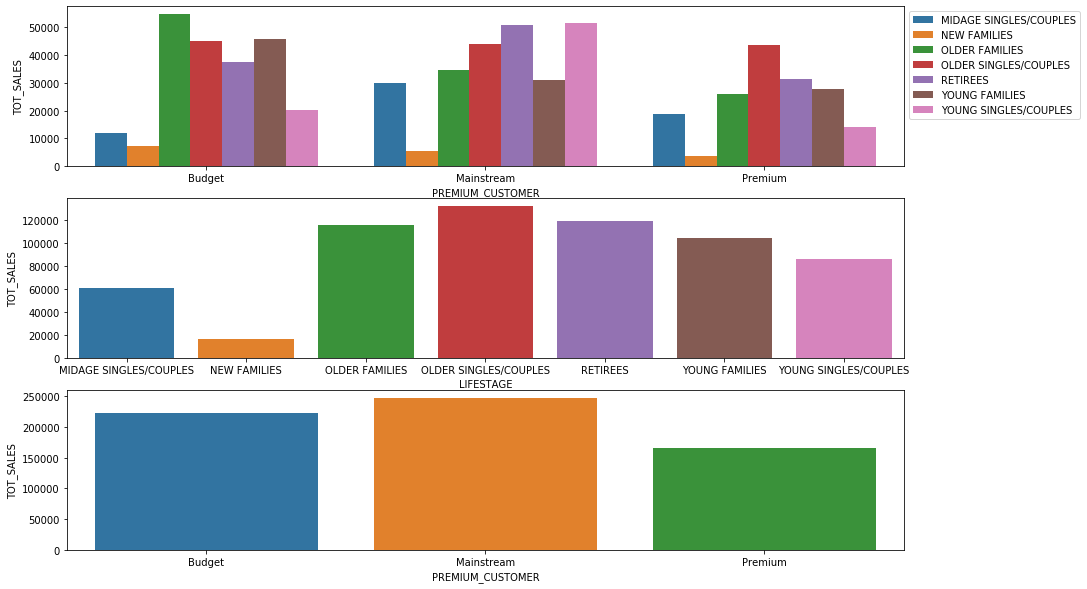

In [245]:
cust_types = cust_trans.pivot_table(index=['PREMIUM_CUSTOMER', 'LIFESTAGE'], values='TOT_SALES', aggfunc='sum')
cust_types_lifestage = cust_trans.pivot_table(index=['LIFESTAGE'], values='TOT_SALES', aggfunc='sum')
cust_types_pre_cust = cust_trans.pivot_table(index=['PREMIUM_CUSTOMER'], values='TOT_SALES', aggfunc='sum')

fig, axs = plt.subplots(3, 1, figsize=(15,10))
sns.barplot(x='PREMIUM_CUSTOMER', y='TOT_SALES', hue='LIFESTAGE', data=cust_types.reset_index(), ax=axs[0])
axs[0].legend(bbox_to_anchor=(1, 1))
sns.barplot(x='LIFESTAGE', y='TOT_SALES', data=cust_types_lifestage.reset_index(), ax=axs[1])
sns.barplot(x='PREMIUM_CUSTOMER', y='TOT_SALES', data=cust_types_pre_cust.reset_index(), ax=axs[2])

### How many customers are in each segment?
Barplot below show that there is a significant number of older singles/couples registered at the store. 

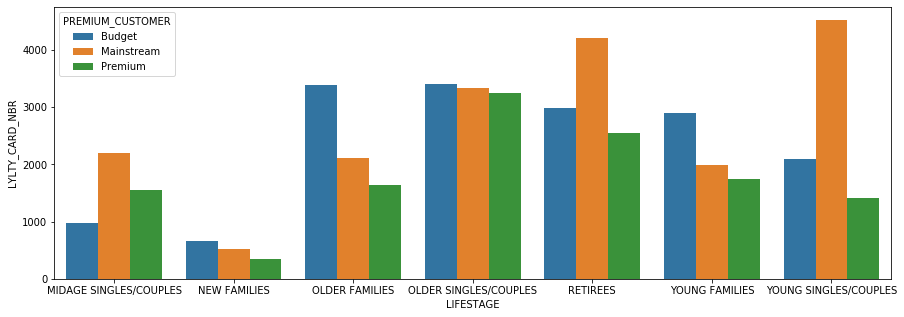

In [268]:
cust_seg = cust_trans.drop_duplicates(subset=['LYLTY_CARD_NBR'])[['LYLTY_CARD_NBR', 'LIFESTAGE', 'PREMIUM_CUSTOMER']]
cust_seg_group = cust_seg.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).agg('count')
plt.figure(figsize=(15,5))
sns.barplot(x='LIFESTAGE', y='LYLTY_CARD_NBR', hue='PREMIUM_CUSTOMER', data=cust_seg_group.reset_index())

### How many chips are bought per customer by segment?
The plots are still quite similar to the total sales computed earlier.

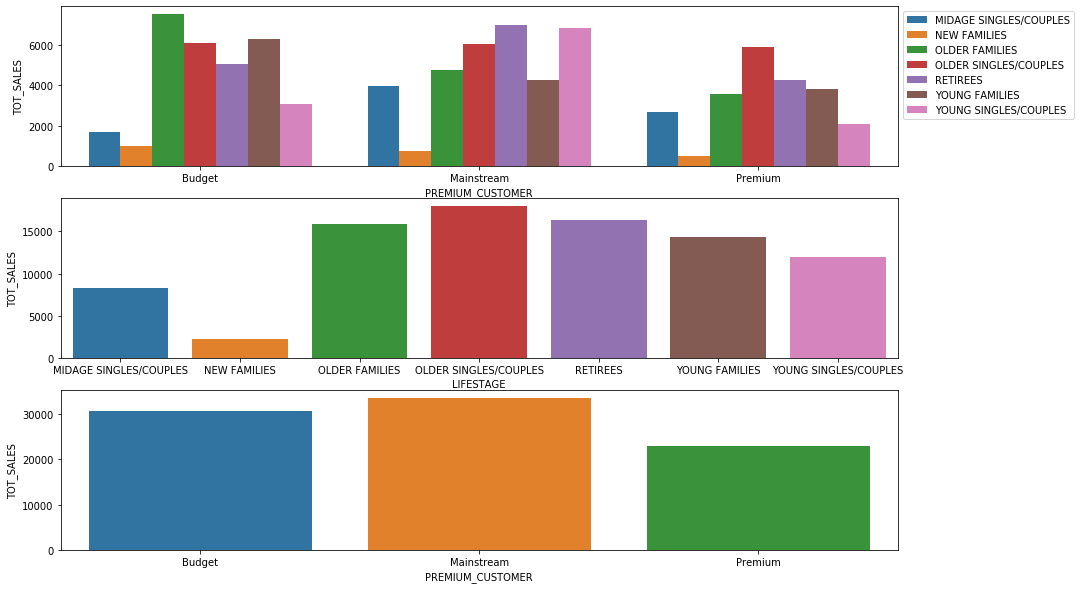

In [270]:
cust_types_count = cust_trans.pivot_table(index=['PREMIUM_CUSTOMER', 'LIFESTAGE'], values='TOT_SALES', aggfunc='count')
cust_types_count_lifestage = cust_trans.pivot_table(index=['LIFESTAGE'], values='TOT_SALES', aggfunc='count')
cust_types_count_pre_cust = cust_trans.pivot_table(index=['PREMIUM_CUSTOMER'], values='TOT_SALES', aggfunc='count')

fig, axs = plt.subplots(3, 1, figsize=(15,10))
sns.barplot(x='PREMIUM_CUSTOMER', y='TOT_SALES', hue='LIFESTAGE', data=cust_types_count.reset_index(), ax=axs[0])
axs[0].legend(bbox_to_anchor=(1, 1))
sns.barplot(x='LIFESTAGE', y='TOT_SALES', data=cust_types_count_lifestage.reset_index(), ax=axs[1])
sns.barplot(x='PREMIUM_CUSTOMER', y='TOT_SALES', data=cust_types_count_pre_cust.reset_index(), ax=axs[2])

### What's the average chip price by customer segment?
For every transaction, the average spending for all segments is about 6-7 dollars.

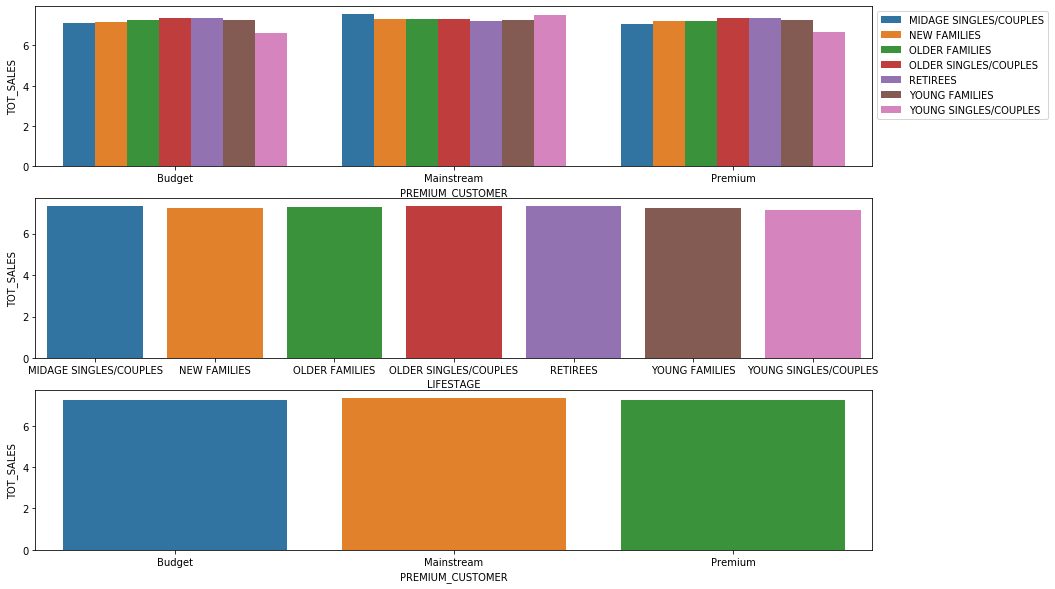

In [271]:
cust_types_count = cust_trans.pivot_table(index=['PREMIUM_CUSTOMER', 'LIFESTAGE'], values='TOT_SALES', aggfunc='mean')
cust_types_count_lifestage = cust_trans.pivot_table(index=['LIFESTAGE'], values='TOT_SALES', aggfunc='mean')
cust_types_count_pre_cust = cust_trans.pivot_table(index=['PREMIUM_CUSTOMER'], values='TOT_SALES', aggfunc='mean')

fig, axs = plt.subplots(3, 1, figsize=(15,10))
sns.barplot(x='PREMIUM_CUSTOMER', y='TOT_SALES', hue='LIFESTAGE', data=cust_types_count.reset_index(), ax=axs[0])
axs[0].legend(bbox_to_anchor=(1, 1))
sns.barplot(x='LIFESTAGE', y='TOT_SALES', data=cust_types_count_lifestage.reset_index(), ax=axs[1])
sns.barplot(x='PREMIUM_CUSTOMER', y='TOT_SALES', data=cust_types_count_pre_cust.reset_index(), ax=axs[2])

### How many returning customers?

We have 47779 number of customer registered in the system
There are 87333 number of transactions made in the system
Only 23054 returning customers in the past.


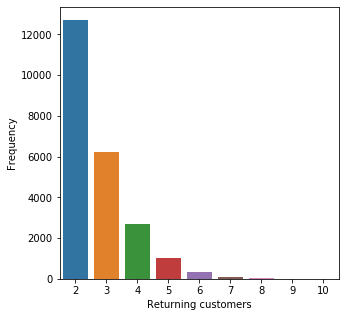

In [298]:
print('We have {} number of customer registered in the system'.format(cust_seg.shape[0]))
print('There are {} number of transactions made in the system'.format(cust_trans.shape[0]))
cust_trans_return_cust = cust_trans.groupby('LYLTY_CARD_NBR').agg('count')
cust_trans_return_cust = cust_trans_return_cust[cust_trans_return_cust['LIFESTAGE'] > 1]

cust_types_return_cust_count = cust_trans_return_cust.pivot_table(index=['PREMIUM_CUSTOMER', 'LIFESTAGE'],
                                                                  values='TOT_SALES', aggfunc='count')
cust_types_return_cust_count_lifestage = cust_trans_return_cust.pivot_table(index=['LIFESTAGE'],
                                                                            values='TOT_SALES', aggfunc='count')
cust_types_return_cust_count_pre_cust = cust_trans_return_cust.pivot_table(index=['PREMIUM_CUSTOMER'],
                                                                           values='TOT_SALES', aggfunc='count')

plt.figure(figsize=(5,5))
sns.barplot(x='LIFESTAGE', y='TOT_SALES', data=cust_types_return_cust_count_lifestage.reset_index())
plt.xlabel('Returning customers')
plt.ylabel('Frequency')

print('Only {} returning customers in the past.'.format(cust_trans_return_cust.shape[0]))

### Which chips is popular?
Take note of the x axis, it is sorted based on the popularity of sales chips.

([], <a list of 0 Text xticklabel objects>)

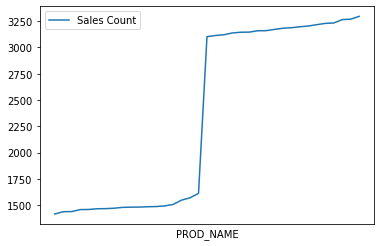

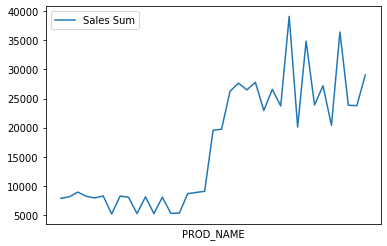

In [246]:
sales_count = cust_trans.pivot_table(index='PROD_NAME', 
                                         aggfunc='count', values='TOT_SALES').sort_values(by='TOT_SALES')
sales_sum = cust_trans.pivot_table(index='PROD_NAME', 
                                       aggfunc='sum', values='TOT_SALES').reindex(sales_count.index)
sales_count.plot()
plt.legend(['Sales Count'])
plt.xticks([])
sales_sum.plot()
plt.legend(['Sales Sum'])
plt.xticks([])

Since we know that the brand of the chips can be split into 2 popular counts, I will name it as cat1 & cat2.

In [299]:
cat2 = sales_count[sales_count['TOT_SALES'] > 2250].index.tolist()
cat1 = sales_count[sales_count['TOT_SALES'] <= 2250].index.tolist()

Low popularity chips as shown in the list below:
['French Fries Potato Chips 175g', 'Smiths Chip Thinly  CutSalt/Vinegr 175g', 'Thins Chips         Originl saltd 175g', 'Natural ChipCo      Hony Soy Chckn 175g', 'Smiths Crinkle Cut  Chips Original 170g', 'Natural Chip        Compny SeaSalt 175g', 'WW D/Style Chip     Sea Salt 200g', 'Smiths Chip Thinly  S/Cream&Onion 175g', 'Smiths Crinkle Cut  Chips Chs&Onion 170g', 'WW Sour Cream &OnionStacked Chips 160g', 'Smiths Crinkle Cut  Chips Chicken 170g', 'WW Original Stacked Chips 160g', 'Smiths Crinkle Cut  Chips Barbecue 170g', 'WW Original Corn    Chips 200g', 'WW Supreme Cheese   Corn Chips 200g', 'Natural ChipCo Sea  Salt & Vinegr 175g', 'Natural Chip Co     Tmato Hrb&Spce 175g', 'Smiths Chip Thinly  Cut Original 175g']


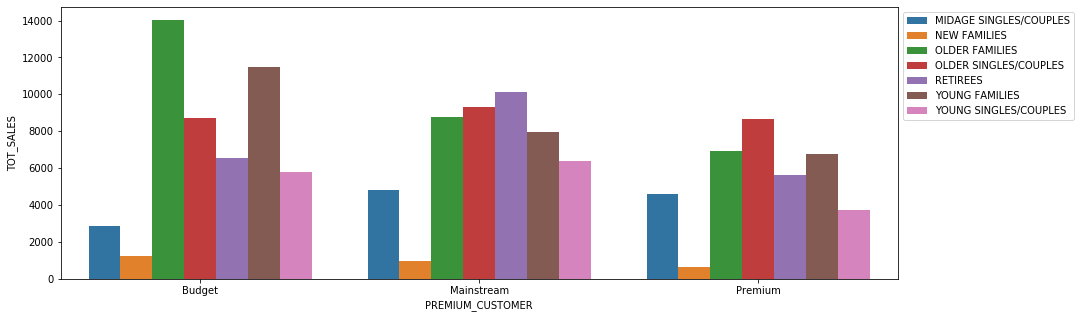

In [300]:
print('Low popularity chips as shown in the list below:')
print(cat1)
cust_trans1 = cust_trans[cust_trans['PROD_NAME'].isin(cat1)]
cust_types1 = cust_trans1.pivot_table(index=['PREMIUM_CUSTOMER', 'LIFESTAGE'], values='TOT_SALES', aggfunc='sum')

plt.figure(figsize=(15,5))
sns.barplot(x='PREMIUM_CUSTOMER', y='TOT_SALES', hue='LIFESTAGE', data=cust_types1.reset_index())
plt.legend(bbox_to_anchor=(1, 1))

High popularity chips as shown in the list below:
['Thins Chips Salt &  Vinegar 175g', 'Thins Chips Seasonedchicken 175g', 'Doritos Corn Chips  Original 170g', 'Kettle Tortilla ChpsFeta&Garlic 150g', 'Tostitos Smoked     Chipotle 175g', 'Kettle Tortilla ChpsBtroot&Ricotta 150g', 'Cobs Popd Sour Crm  &Chives Chips 110g', 'Doritos Corn Chips  Nacho Cheese 170g', 'Doritos Corn Chip Southern Chicken 150g', 'Dorito Corn Chp     Supreme 380g', 'Thins Chips Light&  Tangy 175g', 'Smiths Crinkle Chips Salt & Vinegar 330g', 'Doritos Corn Chip Mexican Jalapeno 150g', 'Doritos Corn Chips  Cheese Supreme 170g', 'Thins Potato Chips  Hot & Spicy 175g', 'Smiths Crnkle Chip  Orgnl Big Bag 380g', 'Cobs Popd Sea Salt  Chips 110g', 'Cobs Popd Swt/Chlli &Sr/Cream Chips 110g', 'Kettle Tortilla ChpsHny&Jlpno Chili 150g']


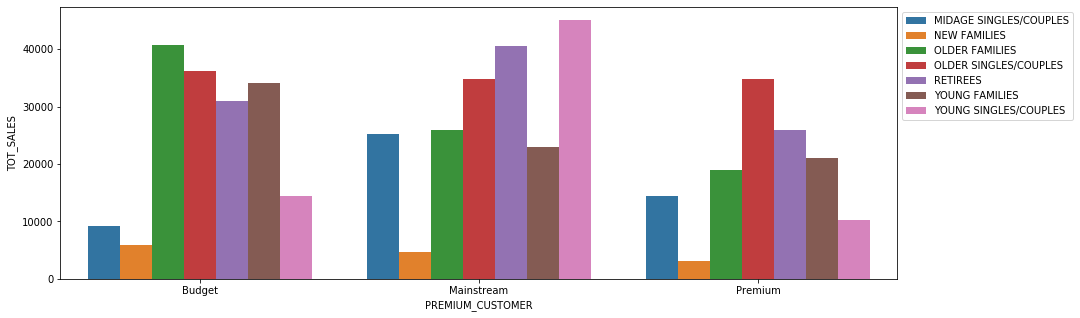

In [304]:
print('High popularity chips as shown in the list below:')
print(cat2)
cust_trans2 = cust_trans[cust_trans['PROD_NAME'].isin(cat2)]
cust_types2 = cust_trans2.pivot_table(index=['PREMIUM_CUSTOMER', 'LIFESTAGE'], values='TOT_SALES', aggfunc='sum')

plt.figure(figsize=(15,5))
sns.barplot(x='PREMIUM_CUSTOMER', y='TOT_SALES', hue='LIFESTAGE', data=cust_types2.reset_index())
plt.legend(bbox_to_anchor=(1, 1))

### Do the customers tend to buy big size of chips?

In [305]:
cust_trans.head()

DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
0 1974-12-13 22:00:00          1            1000       1         5   
1 1974-12-22 21:00:00          1            1343     383        61   
2 1974-12-11 09:00:00          2            2373     974        69   
3 1974-12-11 10:00:00          2            2426    1038       108   
4 1974-12-22 17:00:00          4            4149    3333        16   

                                  PROD_NAME  PROD_QTY  TOT_SALES    BRAND  \
0   Natural Chip        Compny SeaSalt 175g         2        6.0  Natural   
1    Smiths Crinkle Cut  Chips Chicken 170g         2        2.9   Smiths   
2    Smiths Chip Thinly  S/Cream&Onion 175g         5       15.0   Smiths   
3  Kettle Tortilla ChpsHny&Jlpno Chili 150g         3       13.8   Kettle   
4  Smiths Crinkle Chips Salt & Vinegar 330g         1        5.7   Smiths   

  PACK_SIZE               LIFESTAGE PREMIUM_CUSTOMER  
0      175g   YOUNG SINGLES/COUPLES          Premium  
1      170g  MIDAGE SINGLES/COUPLES           Budget  
2      175g  MIDAGE SINGLES/COUPLES           Budget  
3      150g  MIDAGE SINGLES/COUPLES           Budget  
4      330g  MIDAGE SINGLES/COUPLES           Budget

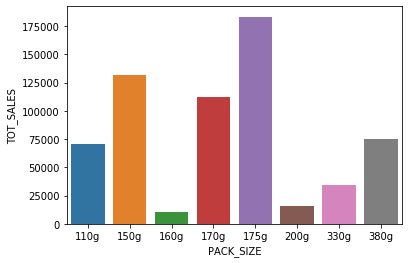

In [313]:
pack_size_sales = cust_trans.pivot_table(index='PACK_SIZE', values='TOT_SALES', aggfunc='sum')
sns.barplot(data=pack_size_sales.reset_index(), x='PACK_SIZE', y='TOT_SALES')

# Conclusion

In conclusion, the client can shift his/ her focus more on the following groups
1. Older singles/couples regardless of its background
2. New families from budget background
3. Retirees from mainstream background

Most of the time, customers will purchase 2 packets of chips. Take it as the base, the client can package the chips into more packets and obtain more sales.

The client can also shift his marketing focus on the following brand:
- Cobs, Doritos, Kettle, Thins, Smiths

The preference of the chip size are 175g, followed by 170g and 150g.